In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')
import random

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib.ticker import MultipleLocator

from util import array2mat, mkdir

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
map_info = pd.read_csv('/lmh_data/data/sclab/sclab/map_result.csv', sep='\t', index_col=0)
rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})

cell_type, marker_gene_name = 'Astro', 'SLC1A2'
gene_name = 'PDGFRA'
eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
preds = np.load('/lmh_data/data/sclab/sclab/tmp/{}/evaluate.npy'.format(gene_name), allow_pickle=True)

In [3]:
rna = rna[map_info.index]
rna = rna[rna.obs['cell_type'].isin([cell_type]),:]
rna.layers["counts"] = rna.X.copy()

In [4]:
_index = []
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
    if eval_set[i]['cell_type'] not in [cell_type]:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            _index.append(_rna[j].obs.index[0])
            
rna = rna[_index]
rna

View of AnnData object with n_obs × n_vars = 43 × 50281
    obs: 'cell_type', 'domain'
    layers: 'counts'

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be

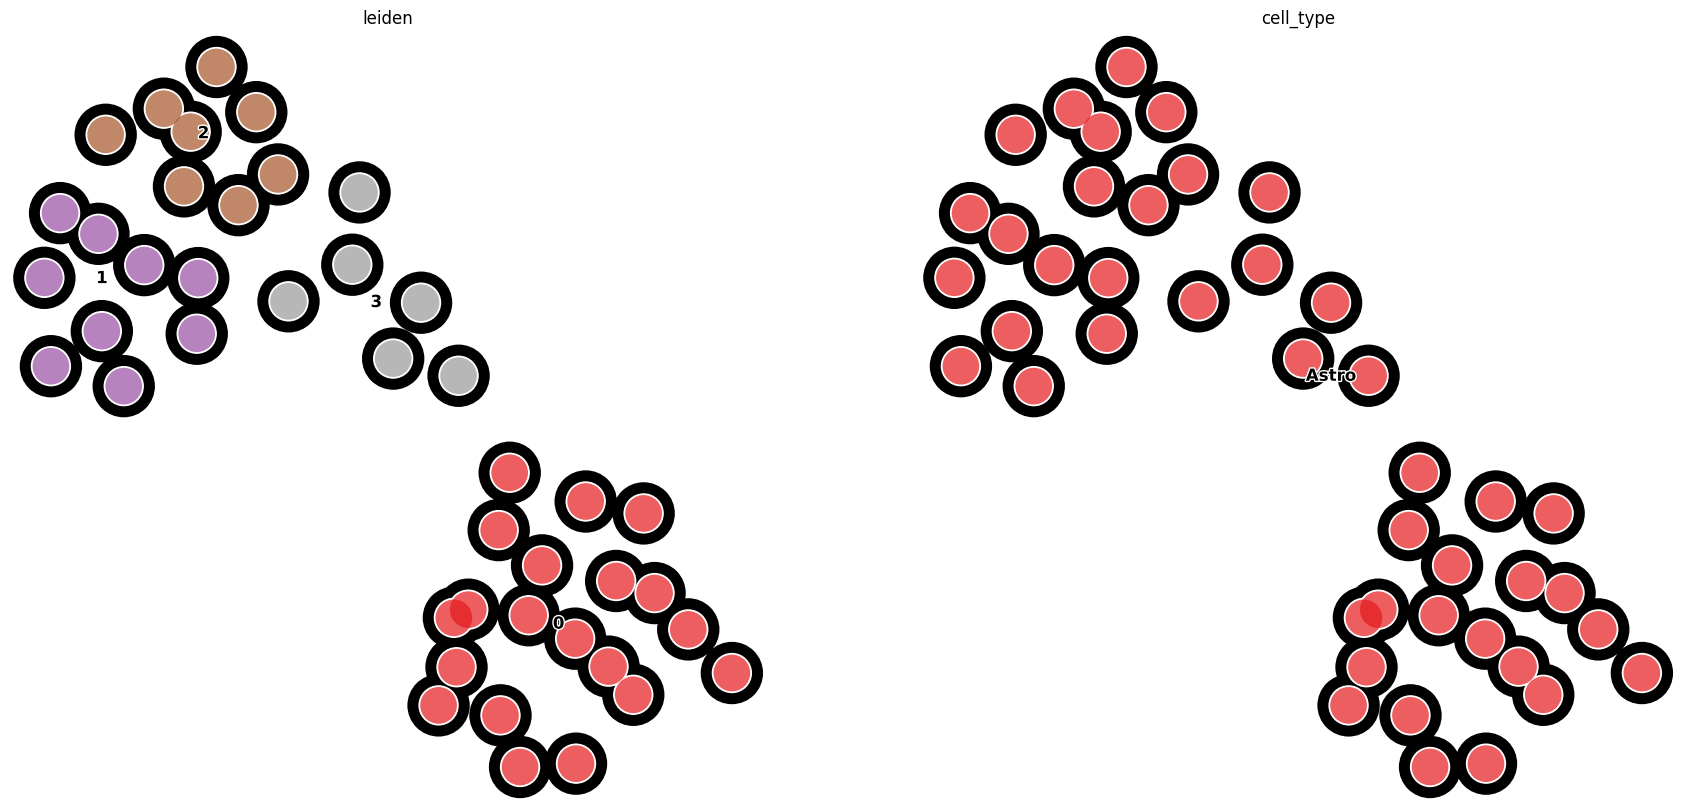

In [5]:
rna.X = rna.layers["counts"].copy()
sc.tl.pca(rna, n_comps=int(rna.shape[0]/5), svd_solver="auto")

sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.tl.leiden(rna)

with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(rna, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

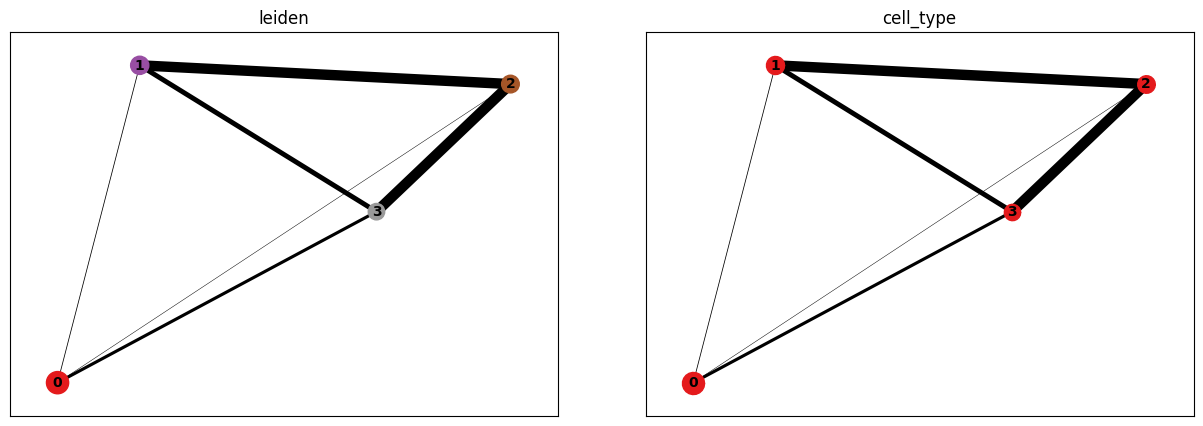

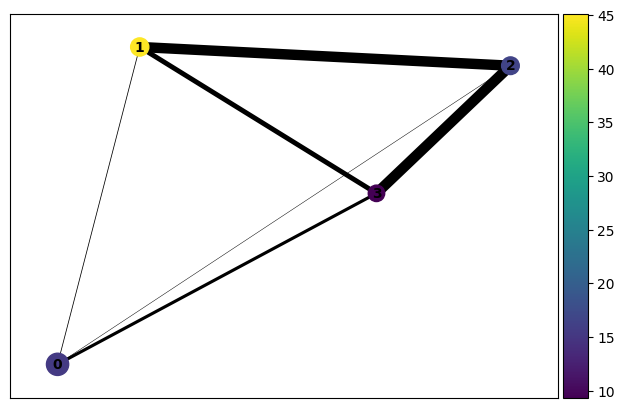

In [6]:
sc.tl.paga(rna, groups='leiden')
sc.pl.paga(rna, color=['leiden', 'cell_type'])
sc.pl.paga(rna, color=[marker_gene_name])

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


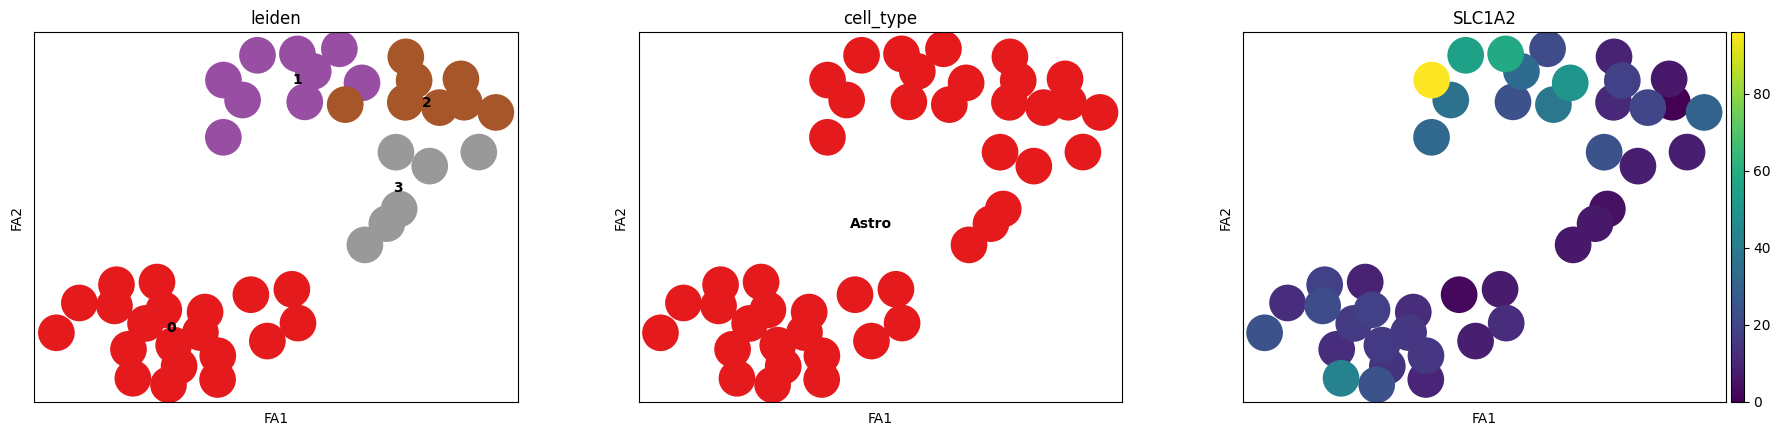

In [7]:
sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', marker_gene_name], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


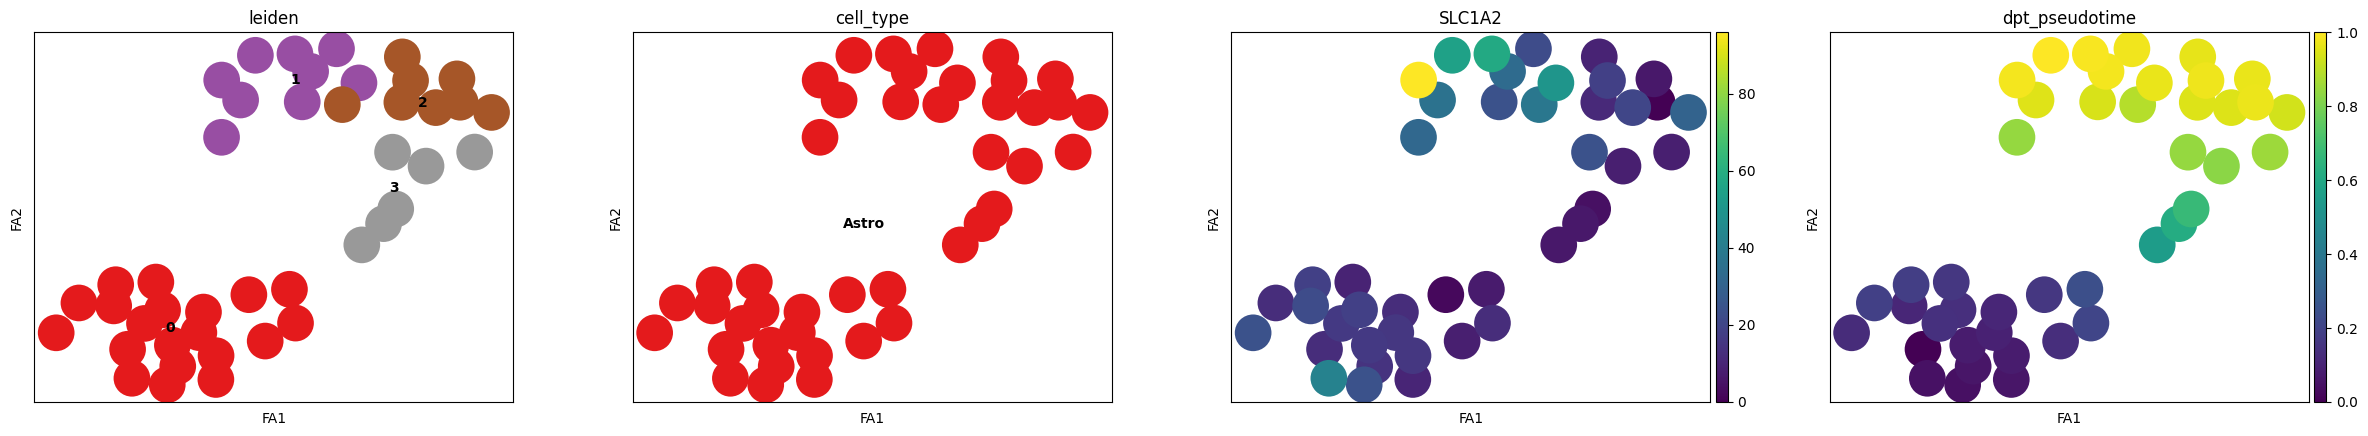

In [8]:
rna.uns['iroot'] = np.flatnonzero(rna.obs['leiden']=='0')[0]
sc.tl.dpt(rna)

sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', marker_gene_name, 'dpt_pseudotime'], legend_loc='on data')

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


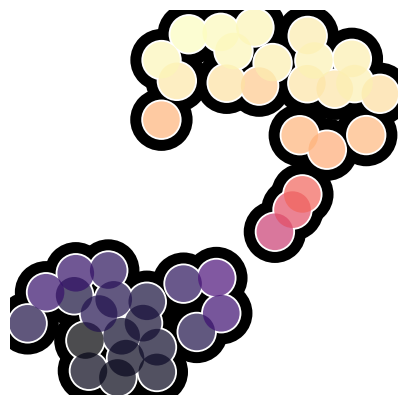

In [9]:
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.draw_graph(rna, color=['dpt_pseudotime'], cmap='magma',
                     add_outline=True, legend_loc=None, colorbar_loc=None, title='', frameon=False, return_fig=True)
#     plt.savefig(
#         '/lmh_data/work/SEE/analyse/figure_file/pseudotime({}).pdf'.format(gene_name),
#         format='pdf', bbox_inches='tight')
    plt.show()

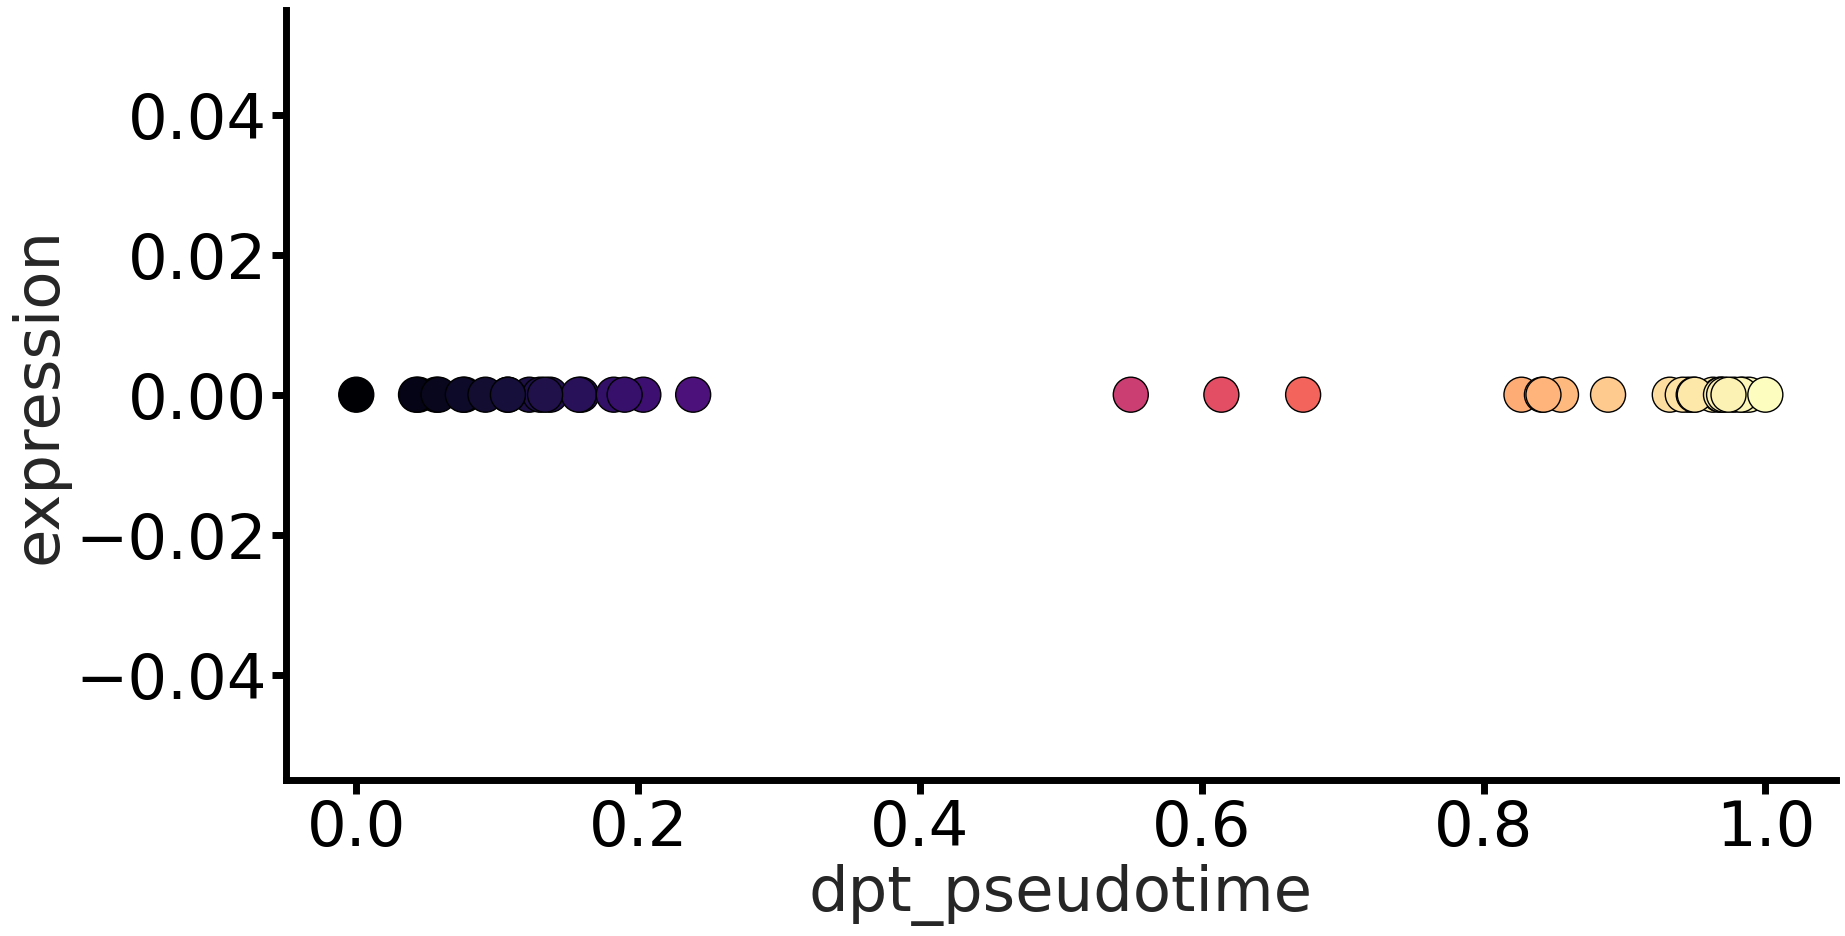

In [10]:
import seaborn as sns
from analyse_util import figure_size, set_plt, set_Border

set_plt(figsize=(20, 10))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

_x, _y = rna.obs['dpt_pseudotime'].values, rna[:, gene_name].layers["counts"].reshape(-1)
ax.scatter(_x, _y, edgecolors='black', s=(figure_size['large']*72./fig.dpi)**2, c=_x, cmap='magma')

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)
plt.xlabel('dpt_pseudotime', fontsize=figure_size['ultra'])
plt.ylabel('expression', fontsize=figure_size['ultra'])
# plt.savefig(
#     '/lmh_data/work/SEE/analyse/figure_file/{} expression(ODC).pdf'.format(gene_name),
#     format='pdf', bbox_inches='tight')
plt.show()

In [11]:
scHiC = {}
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
    if eval_set[i]['cell_type'] not in [cell_type]:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            scHiC[_rna[j].obs_names[0]] = preds[i]['predict']
            break
scHiC

{'TTACCATCACAGCCAC-LKTX_190130_01_E01': array([ 4.6904084e-01,  1.3170247e-03, -2.3808729e-02, -3.5510231e-03,
         4.5328252e-03,  6.3286740e-03, -2.9650610e-04, -4.9770474e-03,
         2.8491095e-01,  5.2875336e-03,  1.9317692e-02,  1.9514602e-02,
        -2.2968145e-02,  2.2998277e-02,  1.3051029e-02,  1.5393627e-01,
         1.6015394e-02, -2.4318630e-03,  6.6368841e-04, -3.0716544e-03,
        -4.8322137e-03,  3.1110731e-01, -9.1066323e-03, -9.6804276e-03,
        -1.3163399e-02,  8.8747758e-03,  3.4372953e-01,  7.5602410e-03,
         1.3068916e-02, -4.1714627e-03,  3.9488038e-01,  1.9598491e-02,
         1.0127366e-02,  3.0188358e-01, -9.2152022e-03,  3.6817497e-01],
       dtype=float32),
 'CTGGTCTGTTTCGCTC-LKTX_190130_01_F01': array([ 6.8522292e-01,  1.2176296e-02, -2.0403638e-02,  4.7100168e-03,
         5.4309294e-03,  8.3706584e-03, -7.2421972e-03, -7.3754117e-03,
         4.4256833e-01,  1.2326306e-02,  2.7299408e-02,  2.0651683e-02,
        -8.9072064e-03,  2.1431105

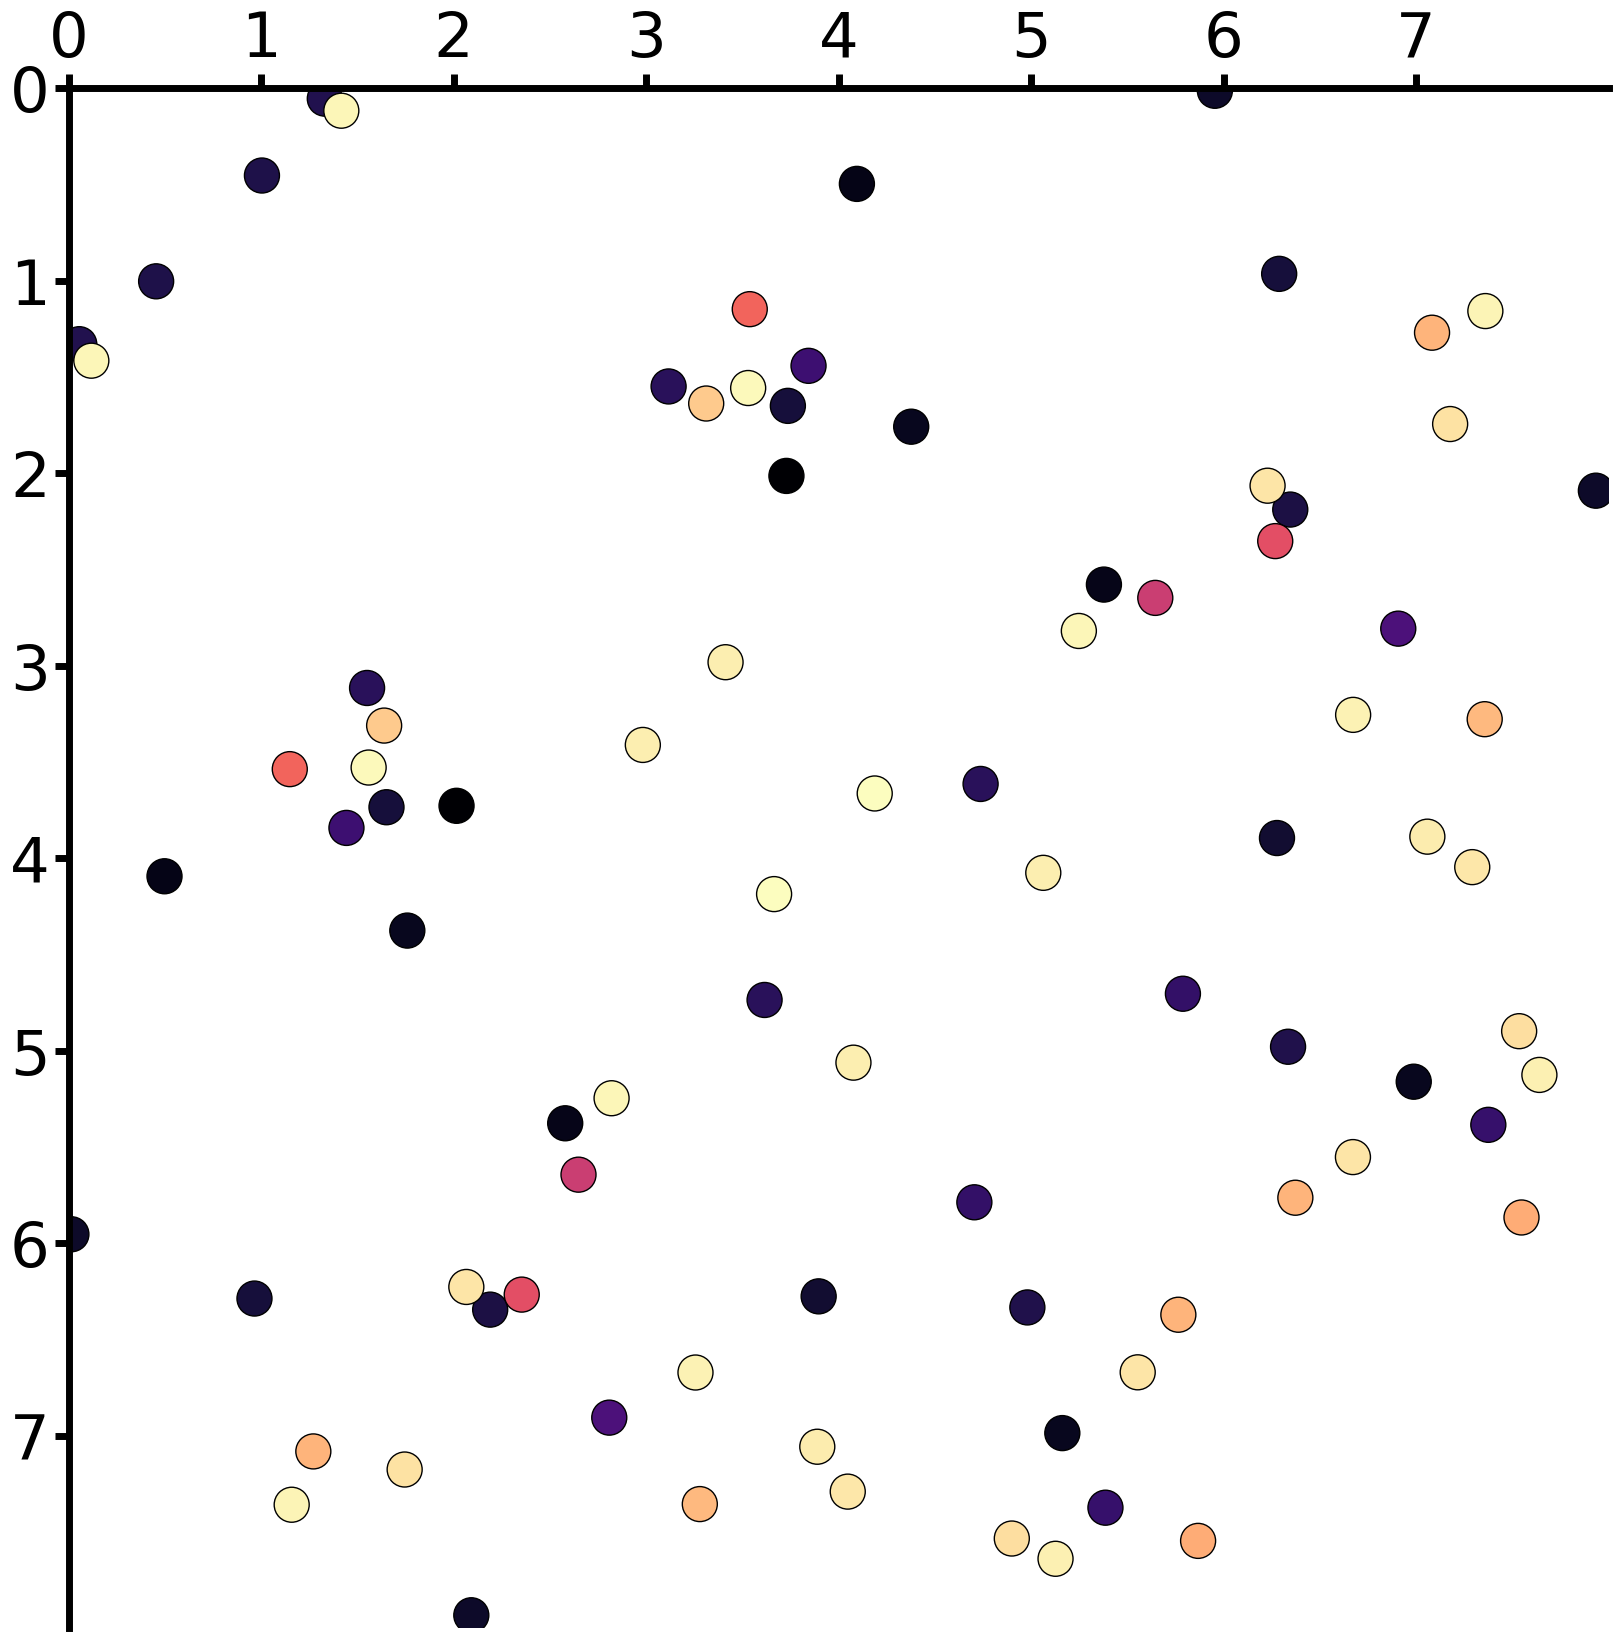

In [12]:
set_plt(figsize=(20, 20))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
set_Border(plt.gca())

_scatter_xs, _scatter_ys = [], []
_pseudotimes = []
_rna_names = []
for rna_name in rna.obs.sort_values(by='dpt_pseudotime').index:
    if rna_name not in scHiC.keys():
        continue
    _pseudotime = rna[rna_name].obs['dpt_pseudotime'].values[0]
    _hic = array2mat(scHiC[rna_name]).copy()
    _hic += abs(_hic.min())
    
    _where = np.where(np.ones(_hic.shape))
    _where = list(zip(_where[0], _where[1]))
    _test = np.zeros(len(_where), dtype=object)
    for i in range(len(_where)):
        _test[i] = _where[i]
    _where = _test
    _p = np.triu(_hic, 1).reshape(-1)
    _p /= _p.sum()

    _scatter_x, _scatter_y = [], []
    for (i, j) in np.random.choice(_where, 1, p=_p):
        _i, _j = random.random()+i, random.random()+j
        if i == j:
            _i, _j = max(_i, _j), min(_i, _j)
        _scatter_x.append(_i)
        _scatter_y.append(_j)

    _i, _j = _scatter_x.copy(), _scatter_y.copy()
    _scatter_x.extend(_j), _scatter_y.extend(_i)

    _scatter_xs.extend(_scatter_x), _scatter_ys.extend(_scatter_y)
    _pseudotimes.extend([_pseudotime]*len(_scatter_x))
    _rna_names.extend([rna_name]*len(_scatter_x))

plt.scatter(_scatter_xs, _scatter_ys, edgecolors='black',
            s=(figure_size['large']*72./fig.dpi)**2, c=_pseudotimes, cmap='magma')

_len = array2mat(scHiC.get(next(iter(scHiC)))).shape[0]
plt.xticks([i for i in range(_len)])
plt.yticks([i for i in range(_len)])
plt.xlim((0, _len))
plt.ylim((0, _len))

ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('none')
ax.spines['top'].set_linewidth(figure_size['very_small'])

ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')

plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['ultra'])
plt.grid(False)
# plt.savefig(
#     '/lmh_data/work/SEE/analyse/figure_file/{} heatmap(ODC).pdf'.format(gene_name),
#     format='pdf', bbox_inches='tight')
plt.show()

In [13]:
_partition = [
    rna.obs[rna.obs.dpt_pseudotime<=0.5],
    rna.obs[rna.obs.dpt_pseudotime>0.5]
]

pseudo_bulk_hic = []

for i in range(len(_partition)):
    _pseudo_bulk = None
    for rna_name in _partition[i].index:
        if rna_name not in scHiC.keys():
            continue

        _hic = array2mat(scHiC[rna_name]).copy()
        _hic += abs(_hic.min())
        if _pseudo_bulk is None:
            _pseudo_bulk = _hic
        else:
            _pseudo_bulk += _hic

    pseudo_bulk_hic.append(_pseudo_bulk / len(_partition[i]))
pseudo_bulk_hic

[array([[0.5352554417, 0.0256900114, 0.0060930763, 0.0203757868,
         0.0287385653, 0.0260765671, 0.0146187983, 0.0131893464],
        [0.0256900114, 0.3269206322, 0.0333763586, 0.0439375043,
         0.0421838078, 0.0022569866, 0.0463503482, 0.0265090642],
        [0.0060930763, 0.0333763586, 0.1762029908, 0.0327690288,
         0.0189008761, 0.0211615474, 0.0212966792, 0.0223655728],
        [0.0203757868, 0.0439375043, 0.0327690288, 0.3684533737,
         0.0141991784, 0.0060434507, 0.0087861899, 0.0266159281],
        [0.0287385653, 0.0421838078, 0.0189008761, 0.0141991784,
         0.3905798457, 0.0286584823, 0.0368525933, 0.0237444486],
        [0.0260765671, 0.0022569866, 0.0211615474, 0.0060434507,
         0.0286584823, 0.4339188269, 0.0463076339, 0.0280194386],
        [0.0146187983, 0.0463503482, 0.0212966792, 0.0087861899,
         0.0368525933, 0.0463076339, 0.3622311219, 0.0114942722],
        [0.0131893464, 0.0265090642, 0.0223655728, 0.0266159281,
         0.0237444

In [14]:
import os
from velocity_util import Calculate_chromatin_conformation

def _draw(mat, title=None, ignore_diag=False):
    set_plt(figsize=(10, 10))
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots()
    
    if ignore_diag:
        mat = mat.copy()
        np.fill_diagonal(mat, 0)
    ax = sns.heatmap(mat, cmap='Greys', square=True)

    set_Border(plt.gca())
    plt.grid(False)
    
    ax.set_xticks([])
    ax.set_yticks([])

#     if title:
#         plt.savefig(
#             '/lmh_data/work/SEE/analyse/figure_file/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()

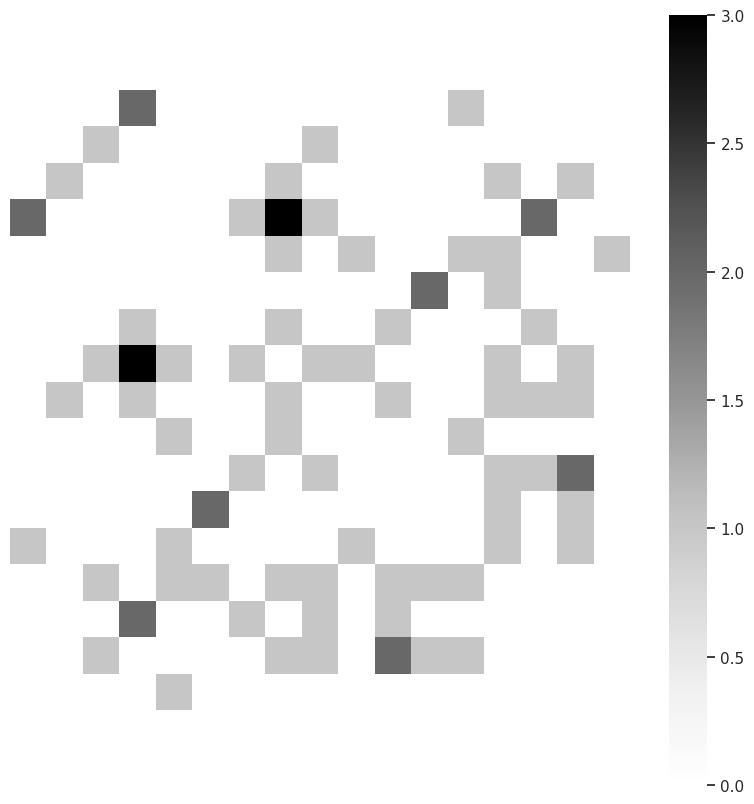

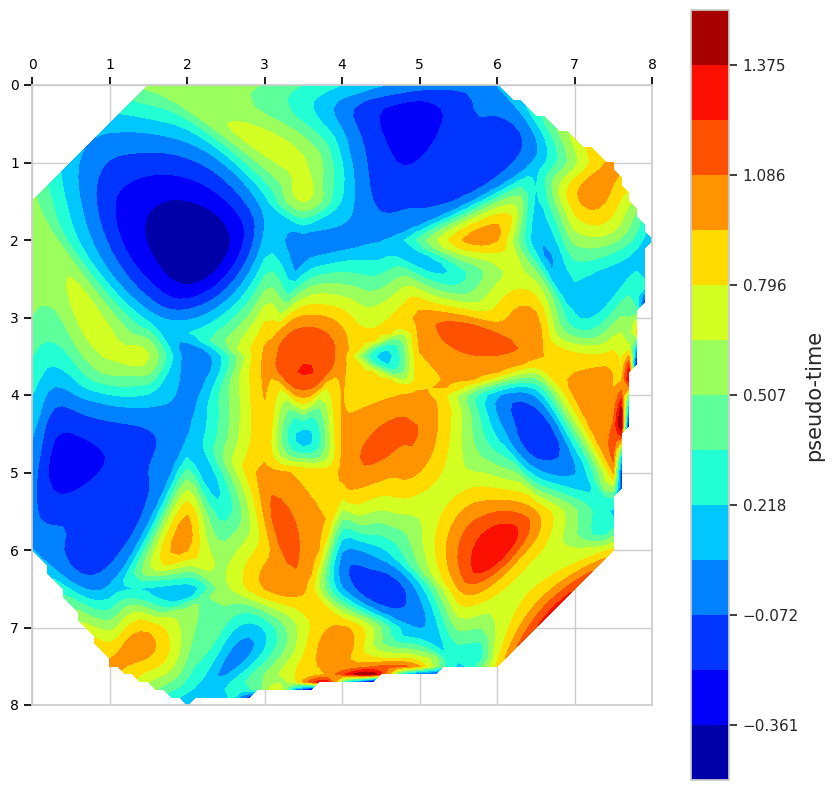

In [15]:
from scipy import interpolate

x = np.linspace(0, _len, _len*2+1)
y = np.linspace(0, _len, _len*2+1)
yy, xx = np.meshgrid(x, y)

def _norm(_decimal):
    if _decimal > 0.5:
        if 1 - _decimal >= _decimal - 0.5:
            return 0.5
        else:
            return 1
    else:
        if 0.5 - _decimal >= _decimal:
            return 0
        else:
            return 0.5

_count = np.zeros(xx.shape)
_value = np.zeros(xx.shape)
for i in range(len(_scatter_xs)):
    _decimal_x, _decimal_y = _scatter_xs[i] - int(_scatter_xs[i]), _scatter_ys[i] - int(_scatter_ys[i])
    _x, _y = int(_scatter_xs[i]) + _norm(_decimal_x), int(_scatter_ys[i]) + _norm(_decimal_y)
    _value[int(_x/0.5), int(_y/0.5)] += _pseudotimes[i]
    _count[int(_x/0.5), int(_y/0.5)] += 1

for i in range(_value.shape[0]):
    for j in range(_value.shape[1]):
        if _count[i, j] != 0:
            _value[i, j] /= _count[i, j]

_value[_count==0] = np.nan
_draw(_count, title='number of interaction occurrences({})'.format(gene_name))




set_plt(figsize=(10, 10))
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

xx[_count==0] = yy[_count==0] = np.nan
xx, yy, new_value = xx.ravel(), yy.ravel(), _value.ravel()
xx, yy, new_value = list(xx[~np.isnan(xx)]), list(yy[~np.isnan(yy)]), list(new_value[~np.isnan(new_value)])

xnew = np.linspace(0, _len, _len*10+1)
ynew = np.linspace(0, _len, _len*10+1)
new_value = interpolate.griddata((xx, yy), new_value, (xnew[None,:], ynew[:,None]), method='cubic')

levels = np.linspace(min(new_value[~np.isnan(new_value)]), max(new_value[~np.isnan(new_value)]), 15)
cs = ax.contourf(xnew, ynew, new_value, levels=levels, cmap=plt.cm.jet)
cbar = plt.colorbar(cs)
cbar.set_label('pseudo-time', rotation=90, fontsize=15) # gas fraction

ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')
plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['small'])

# plt.savefig(
#     '/lmh_data/work/SEE/analyse/figure_file/interactions distribution({}).pdf'.format(gene_name),
#     format='pdf', bbox_inches='tight')

plt.show()

In [16]:
def get_pseudo_bulk_hic(_index):
    _pseudo_bulk = None
    for rna_name in set(np.array(_rna_names)[_index]):
        if rna_name not in scHiC.keys():
            continue

        _hic = array2mat(scHiC[rna_name]).copy()
        _hic += abs(_hic.min())
        if _pseudo_bulk is None:
            _pseudo_bulk = _hic
        else:
            _pseudo_bulk += _hic
    return _pseudo_bulk / len(set(np.array(_rna_names)[_index]))

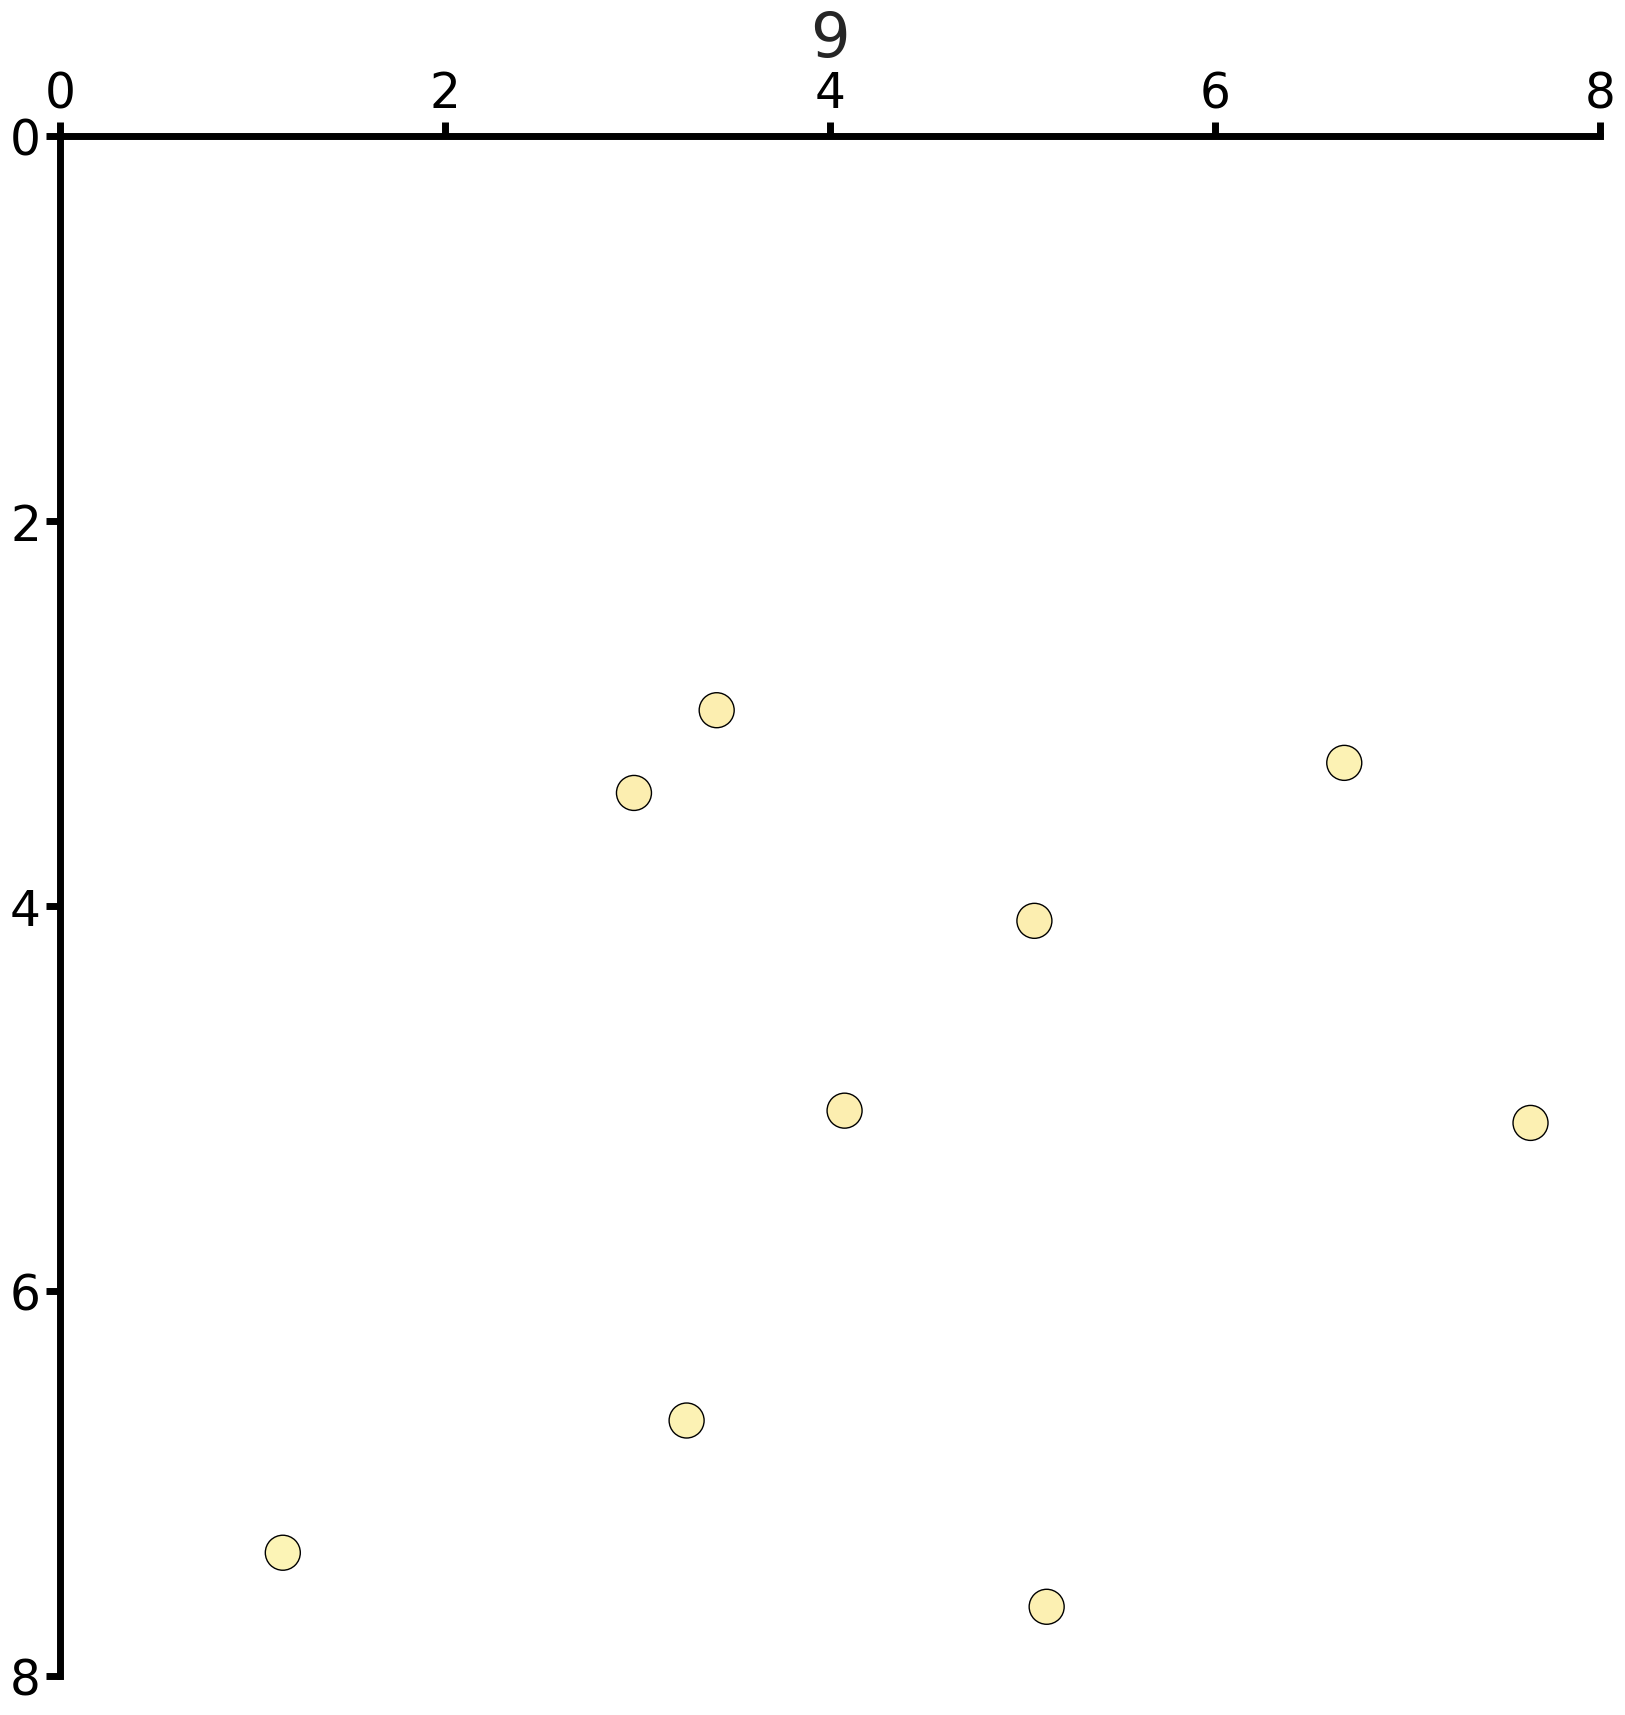

In [17]:
from IPython import display

_array_x, _array_y = np.array(_scatter_xs), np.array(_scatter_ys)
_array_pseudotimes = np.array(_pseudotimes)
_step = 10
for i in range(_step, 100, _step):
    _index = range(int(len(_array_pseudotimes)*(i-_step)/100), int(len(_array_pseudotimes)*(i)/100))
    if len(_index) == 0:
        continue
        
    set_plt(figsize=(20, 20))
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots()
    set_Border(plt.gca())

    plt.scatter(_array_x[_index], _array_y[_index], edgecolors='black',
            s=(figure_size['large']*72./fig.dpi)**2, c=_array_pseudotimes[_index], cmap='magma', vmin=0, vmax=1)
    Calculate_chromatin_conformation(get_pseudo_bulk_hic(_index)*1000, './{}_{}/{}'.format(gene_name, cell_type, int(i/_step)))

    plt.xlim((0, _len))
    plt.ylim((0, _len))

    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('none')
    ax.spines['top'].set_linewidth(figure_size['very_small'])

    ax.xaxis.set_ticks_position('top')
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')

    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(2))
    
    plt.tick_params(colors='black', top=True, bottom=False, left=True, labelsize=figure_size['large'])
    plt.grid(False)
    
    plt.title('{}'.format(int(i/_step)), fontsize=figure_size['ultra'])
    file_name = '/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}_{}/2D/{}.pdf'.format(gene_name, cell_type, int(i/_step))
    mkdir(file_name)
    plt.savefig(file_name, format='pdf', bbox_inches='tight')
    
    display.clear_output(wait=True)
    plt.pause(0.00000001)

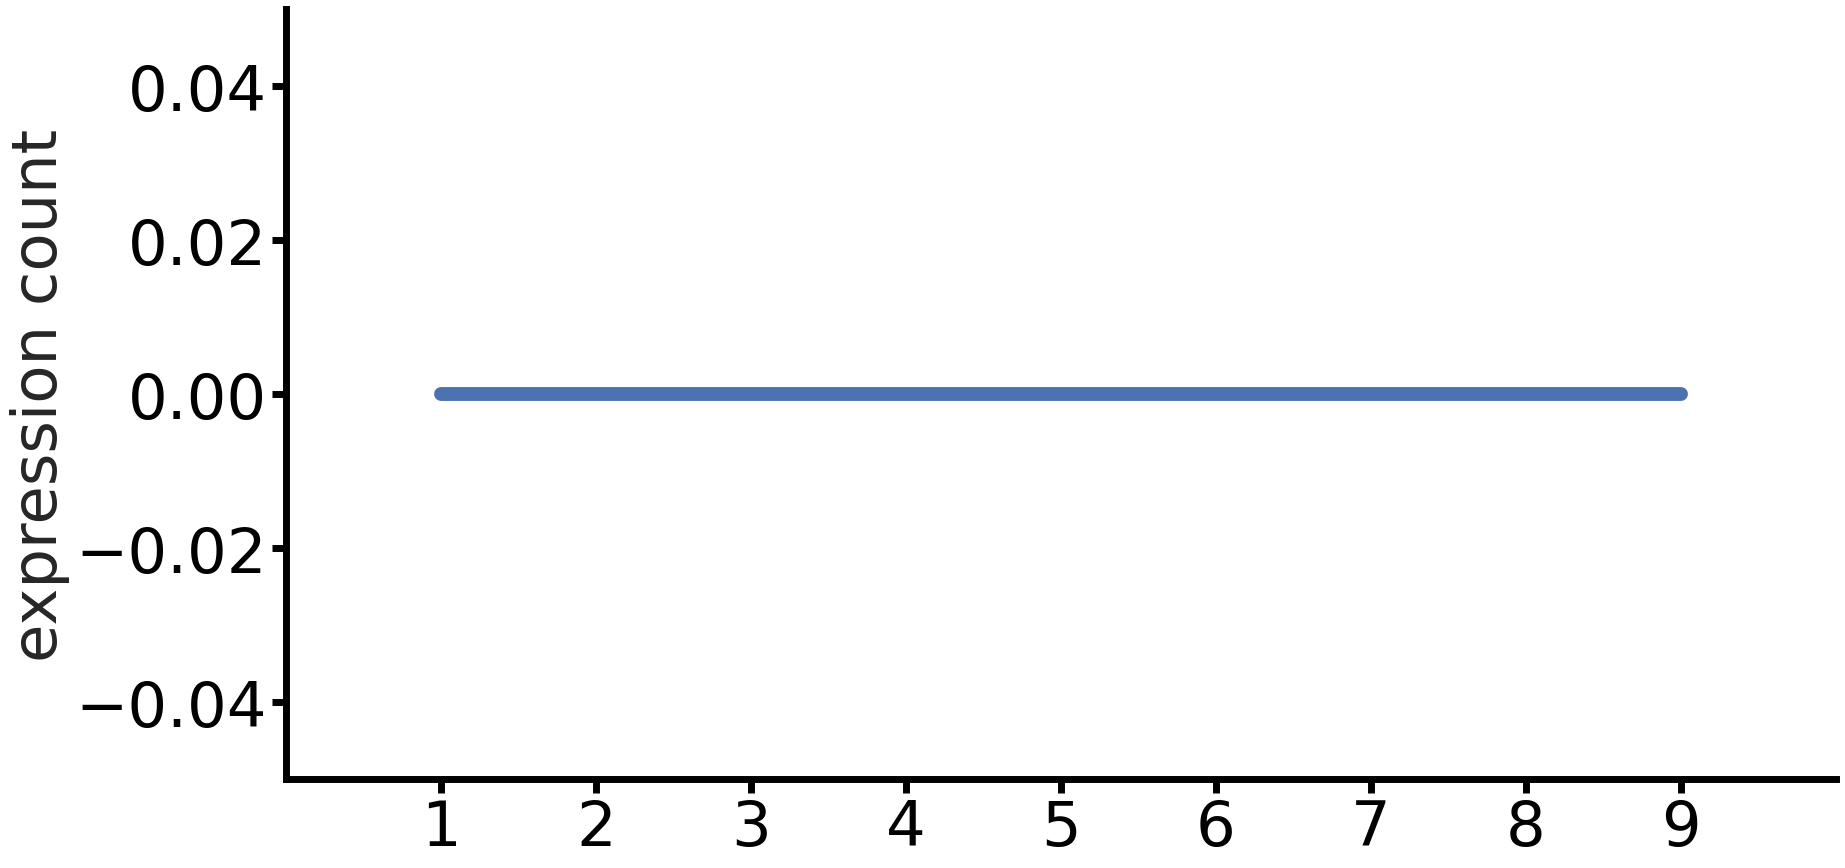

In [18]:
_expression_counts = []
for i in range(_step, 100, _step):
    _index = range(int(len(_array_pseudotimes)*(i-_step)/100), int(len(_array_pseudotimes)*(i)/100))
    if len(_index) == 0:
        continue
    _expression_counts.append(rna[list(set(np.array(_rna_names)[_index])), gene_name].X.mean())

from analyse_util import draw_pseudotime_line
mkdir('/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}/rna'.format(gene_name))
draw_pseudotime_line(_expression_counts, ylabel='expression count',
                     save_dir_path='/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}_{}/rna'.format(gene_name, cell_type))

In [19]:
from velocity_util import find_best_pdb, read_pdb

pseudo_time = [str(i) for i in range(1, 10)]
pseudo_time_3D = dict()

for _dir in pseudo_time:
    _pdb_path = find_best_pdb('./{}_{}/{}'.format(gene_name, cell_type, _dir))
    pseudo_time_3D[_dir] = read_pdb(_pdb_path)
    
pseudo_time_3D

{'1': array([[ 4.384,  3.437,  5.226],
        [ 2.81 ,  1.828, -5.73 ],
        [-4.576, -2.237, -4.477],
        [ 4.231, -3.275, -1.038],
        [ 0.98 ,  5.798, -0.383],
        [-5.028,  1.922,  6.568],
        [-5.171,  4.613, -0.712],
        [-1.827, -3.884,  2.608]]),
 '2': array([[-2.947,  6.045,  0.247],
        [ 2.233, -2.196,  5.507],
        [ 3.962, -1.376, -4.424],
        [ 6.123,  1.971,  2.118],
        [-3.064,  0.801,  3.587],
        [-5.619, -0.923, -5.288],
        [-4.961, -4.629,  1.568],
        [ 1.013, -6.157, -1.427]]),
 '3': array([[-1.294,  6.707,  1.831],
        [ 1.933, -2.37 ,  6.402],
        [ 2.889, -5.433, -1.235],
        [ 5.476,  2.423,  2.119],
        [-4.477,  0.921,  4.641],
        [-5.006,  1.921, -4.655],
        [-4.587, -4.369, -0.065],
        [ 2.502,  1.328, -4.704]]),
 '4': array([[-4.928, -2.49 ,  3.772],
        [-2.572,  5.301, -3.203],
        [ 3.512,  1.499, -6.36 ],
        [-5.13 , -0.531, -5.257],
        [-0.432,  1.85

In [20]:
def rotate(points1, points2):
    if (points1 == points2).all():
        return points1
    # 求解协方差矩阵C
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)
    demeaned1 = points1 - centroid1
    demeaned2 = points2 - centroid2
    C = np.dot(demeaned1.T, demeaned2)

    # 使用SVD分解C得到旋转矩阵R
    U, S, Vt = np.linalg.svd(C)
    R = np.dot(U, Vt)
    
    points_rotated = np.dot(points2, R)
    return points_rotated

for i in pseudo_time:
    pseudo_time_3D[i] = rotate(pseudo_time_3D[pseudo_time[0]], pseudo_time_3D[i])

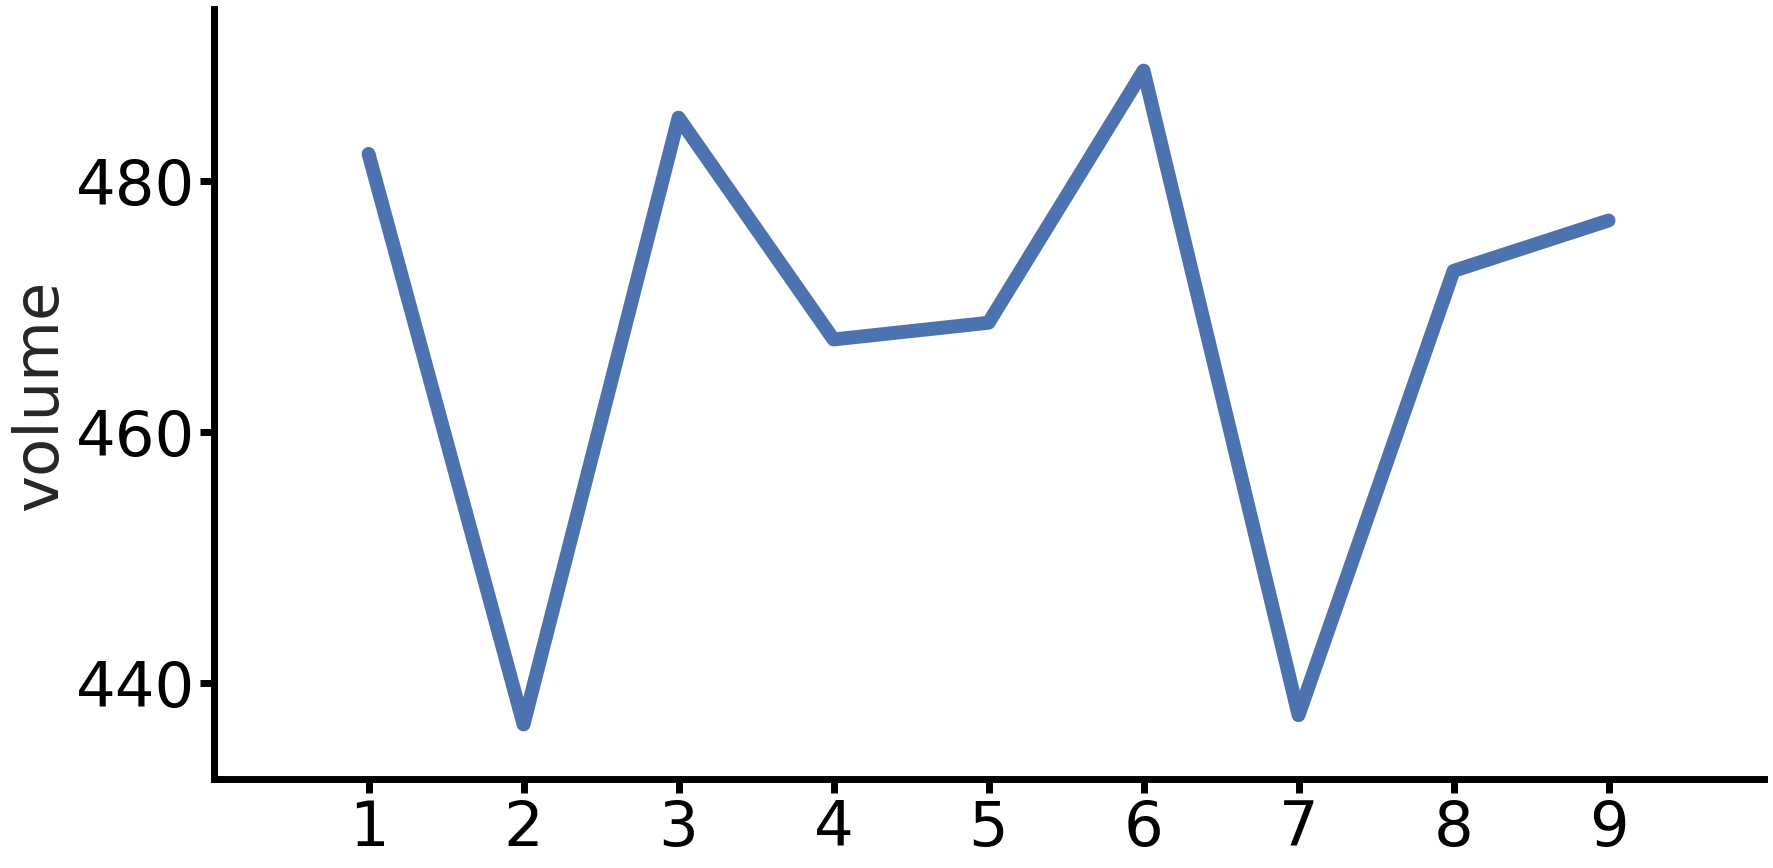

In [21]:
from scipy.spatial import ConvexHull

def calculate_volume(points):
    return ConvexHull(points).volume
volumes = [calculate_volume(pseudo_time_3D[i]) for i in pseudo_time]

from analyse_util import draw_pseudotime_line
mkdir('/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}_{}/volume'.format(gene_name, cell_type))
draw_pseudotime_line(volumes, ylabel='volume',
                     save_dir_path='/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}_{}/volume'.format(gene_name, cell_type))

In [22]:
np.save('./temp/{}_{}.npy'.format(gene_name, cell_type), {
    'expression_counts': _expression_counts,
    'volumes': volumes,
})